In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.cluster import KMeans
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings('ignore')
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

Data Loading and Initial Exploration
python

In [5]:

# Load and combine datasets
file1 = pd.read_csv("Customer_Churn_data.csv")
file2 = pd.read_csv("Customer_Churn_data_2.csv")

In [6]:
# Combine datasets
data = pd.concat([file1, file2], ignore_index=True)

In [7]:
# Convert date columns
data['last_interaction_date'] = pd.to_datetime(data['last_interaction_date'])
data['signup_date'] = pd.to_datetime(data['signup_date'])

print(f"Dataset shape: {data.shape}")
print(f"Churn rate: {data['churn'].mean():.2%}")


   
   # Display first few rows of the dataset
data.head()


Dataset shape: (200000, 15)
Churn rate: 50.01%


,customer_id,customer_email,age,senior_citizen,partner,dependents,tenure_months,phone_service,paperless_billing,monthly_charges,total_charges,churn,last_interaction_date,region,signup_date
0,0f1eb305-e440-4576-9ab0-f8bdbf0bd17b,Preston.Cartwright54@hotmail.com,74,True,False,True,50,True,True,104.265791,1647.518754,False,2024-08-16 21:32:39.602000+00:00,Ohio,NaT
1,0e0237a0-dc14-4610-9c74-5f50d72dd00a,Agustin_Treutel@yahoo.com,43,False,False,True,28,True,True,116.143274,4882.935552,False,2025-01-11 09:46:16.708000+00:00,Oklahoma,NaT
2,b5b9e32b-7332-42d5-a003-14150c2f0097,Maud47@yahoo.com,53,False,False,True,21,False,False,106.498230,6143.648727,True,2024-09-06 23:20:50.027000+00:00,Massachusetts,NaT
3,2a3577e1-6851-4d44-be14-c952fdf9b59b,Curt.Collins84@gmail.com,47,True,True,True,72,True,False,86.835176,5933.628877,True,2025-03-09 07:33:07.830000+00:00,New Mexico,NaT
4,105d0f7f-3885-4811-b465-2c46d4cb9b8b,Waino_Dibbert@gmail.com,41,False,True,True,41,False,False,109.869838,649.543888,True,2025-05-20 08:53:44.748000+00:00,Ohio,NaT


##Exploratory Data Analysis


Text(0, 0.5, 'Count')

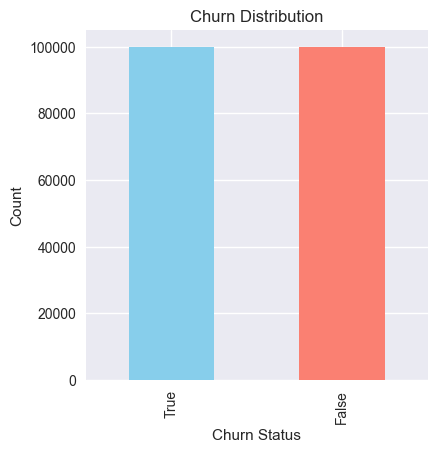

In [8]:
# 1. Churn Distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
data['churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Count')

Text(0.5, 1.0, 'Age Distribution by Churn')

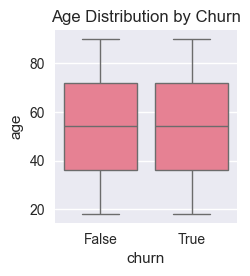

In [9]:
# 2. Age vs Churn
plt.subplot(2, 3, 2)
sns.boxplot(x='churn', y='age', data=data)
plt.title('Age Distribution by Churn')

Text(0.5, 1.0, 'Tenure Distribution by Churn')

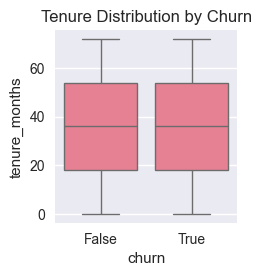

In [10]:
# 3. Tenure vs Churn
plt.subplot(2, 3, 3)
sns.boxplot(x='churn', y='tenure_months', data=data)
plt.title('Tenure Distribution by Churn')

Text(0.5, 1.0, 'Monthly Charges by Churn')

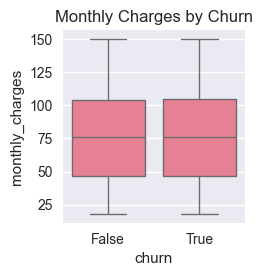

In [11]:
# 4. Monthly Charges vs Churn
plt.subplot(2, 3, 4)
sns.boxplot(x='churn', y='monthly_charges', data=data)
plt.title('Monthly Charges by Churn')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Minnesota'),
  Text(1, 0, 'Massachusetts'),
  Text(2, 0, 'Utah'),
  Text(3, 0, 'Indiana'),
  Text(4, 0, 'Iowa'),
  Text(5, 0, 'South Dakota'),
  Text(6, 0, 'Montana'),
  Text(7, 0, 'Florida'),
  Text(8, 0, 'Wisconsin'),
  Text(9, 0, 'Mississippi')])

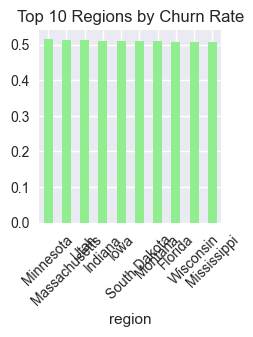

In [12]:
# 5. Regional Churn Analysis
plt.subplot(2, 3, 5)
regional_churn = data.groupby('region')['churn'].mean().sort_values(ascending=False)[:10]
regional_churn.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Regions by Churn Rate')
plt.xticks(rotation=45)

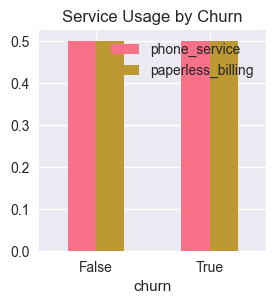

In [13]:
# 6. Service Usage Patterns
plt.subplot(2, 3, 6)
service_usage = data[['phone_service', 'paperless_billing', 'churn']].groupby('churn').mean()
service_usage.plot(kind='bar', ax=plt.gca())
plt.title('Service Usage by Churn')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


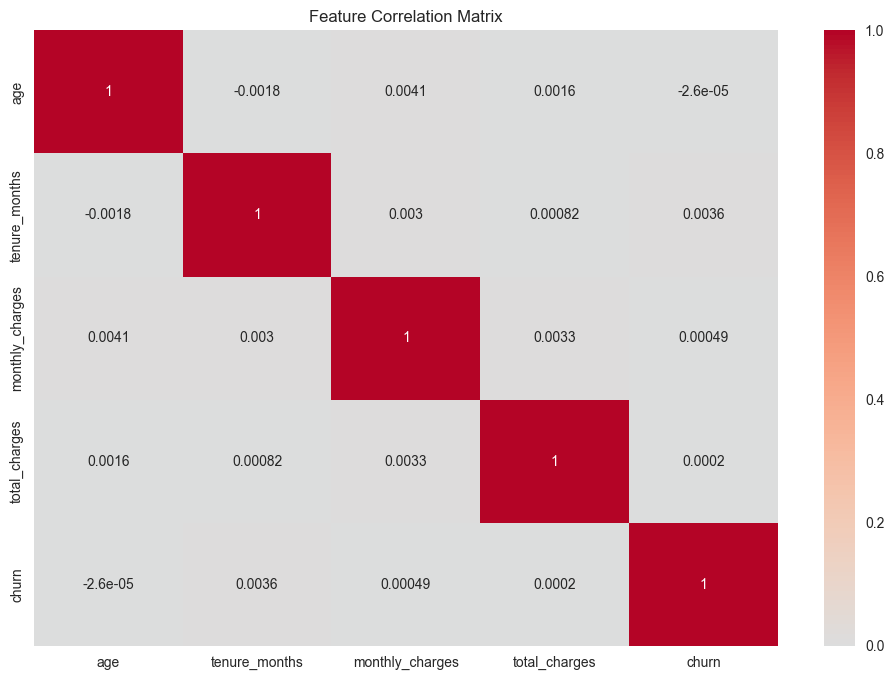

In [14]:
# Correlation Analysis
plt.figure(figsize=(12, 8))
numeric_cols = ['age', 'tenure_months', 'monthly_charges', 'total_charges']
                
correlation_matrix = data[numeric_cols + ['churn']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

Data Preprocessing

In [15]:
def preprocess_data(df):
    """
    Preprocess the data for machine learning
    """
    df_processed = df.copy()
    
    # Convert boolean columns to numeric
    bool_columns = ['senior_citizen', 'partner', 'dependents', 'phone_service', 
                   'paperless_billing', 'churn', 'complaint_indicator']
    for col in bool_columns:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].astype(int)
    
    # Handle categorical variables
    categorical_columns = ['region']
    for col in categorical_columns:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
    
    # Select features for modeling
    feature_columns = [
        'age', 'senior_citizen', 'partner', 'dependents', 'tenure_months',
        'phone_service', 'paperless_billing', 'monthly_charges', 'total_charges',
        'days_since_last_interaction', 'recharge_frequency', 'usage_intensity',
        'value_for_money', 'complaint_indicator', 'region_encoded'
    ]
    
    # Remove any columns that might not exist
    feature_columns = [col for col in feature_columns if col in df_processed.columns]
    
    X = df_processed[feature_columns]
    y = df_processed['churn']
    
    return X, y, feature_columns

# Preprocess data
X, y, feature_columns = preprocess_data(data)

print(f"Features: {feature_columns}")
print(f"Target variable shape: {y.shape}")
print(f"Feature matrix shape: {X.shape}")


Features: ['age', 'senior_citizen', 'partner', 'dependents', 'tenure_months', 'phone_service', 'paperless_billing', 'monthly_charges', 'total_charges', 'region_encoded']
Target variable shape: (200000,)
Feature matrix shape: (200000, 10)


Customer Segmentation

  File "c:\Users\user\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\user\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\user\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Customer Segment Analysis:
                      churn  tenure_months  monthly_charges  total_charges  \
segment_name                                                                 
At Risk Customers       0.5          15.97            49.69        3781.74   
Dormant Customers       0.5          34.18           105.06        6230.15   
High Value Customers    0.5          37.88           105.47        1817.23   
Loyal Customers         0.5          55.97            49.64        4191.99   

                        age  
segment_name                 
At Risk Customers     53.98  
Dormant Customers     54.02  
High Value Customers  54.13  
Loyal Customers       54.00  


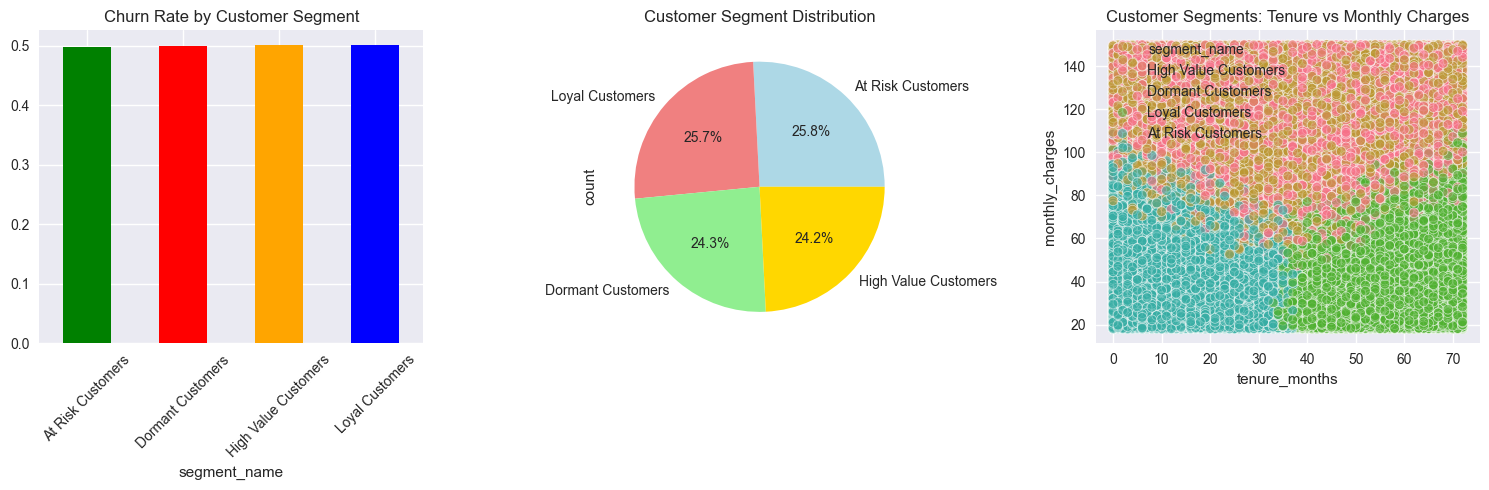

In [16]:
def create_customer_segments(df, n_clusters=4):
    """
    Create customer segments based on behavior patterns
    """
    segmentation_features = [
        'tenure_months', 'monthly_charges', 'total_charges', 
        'days_since_last_interaction', 'recharge_frequency'
    ]
    
    # Select only existing features
    seg_features = [f for f in segmentation_features if f in df.columns]
    
    X_seg = df[seg_features].fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_seg)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    segments = kmeans.fit_predict(X_scaled)
    
    # Analyze segments
    df_segmented = df.copy()
    df_segmented['segment'] = segments
    
    # Map segments to meaningful names
    segment_mapping = {
        0: 'Loyal Customers',
        1: 'At Risk Customers', 
        2: 'Dormant Customers',
        3: 'High Value Customers'
    }
    
    df_segmented['segment_name'] = df_segmented['segment'].map(segment_mapping)
    
    return df_segmented, kmeans, scaler

# Create segments
data_segmented, kmeans_model, scaler = create_customer_segments(data)

# Analyze segments
segment_analysis = data_segmented.groupby('segment_name').agg({
    'churn': 'mean',
    'tenure_months': 'mean',
    'monthly_charges': 'mean',
    'total_charges': 'mean',
    'age': 'mean',

}).round(2)

print("Customer Segment Analysis:")
print(segment_analysis)

# Visualize segments
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
segment_churn = data_segmented.groupby('segment_name')['churn'].mean()
segment_churn.plot(kind='bar', color=['green', 'red', 'orange', 'blue'])
plt.title('Churn Rate by Customer Segment')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
segment_size = data_segmented['segment_name'].value_counts()
segment_size.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Customer Segment Distribution')

plt.subplot(1, 3, 3)
sns.scatterplot(data=data_segmented, x='tenure_months', y='monthly_charges', 
                hue='segment_name', alpha=0.6)
plt.title('Customer Segments: Tenure vs Monthly Charges')

plt.tight_layout()
plt.show()


Model Building

In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)    
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}")
    print("-" * 50)

# Find best model
best_model_name = max(results, key=lambda x: results[x]['auc'])
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")

# Feature Importance using ELI5
print("\nFeature Importance Analysis:")
if hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
else:
    # For linear models, use permutation importance
    perm = PermutationImportance(best_model, random_state=42).fit(X_test, y_test)
    eli5.show_weights(perm, feature_names=feature_columns)


Training Logistic Regression...
Logistic Regression - Accuracy: 0.5046, AUC: 0.5071
--------------------------------------------------
Training Random Forest...
Random Forest - Accuracy: 0.5066, AUC: 0.5060
--------------------------------------------------
Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.5017, AUC: 0.5013
--------------------------------------------------

Best Model: Logistic Regression

Feature Importance Analysis:


Model Evaluation and Business Insights

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     19997
           1       0.50      0.51      0.51     20003

    accuracy                           0.50     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.50      0.50      0.50     40000



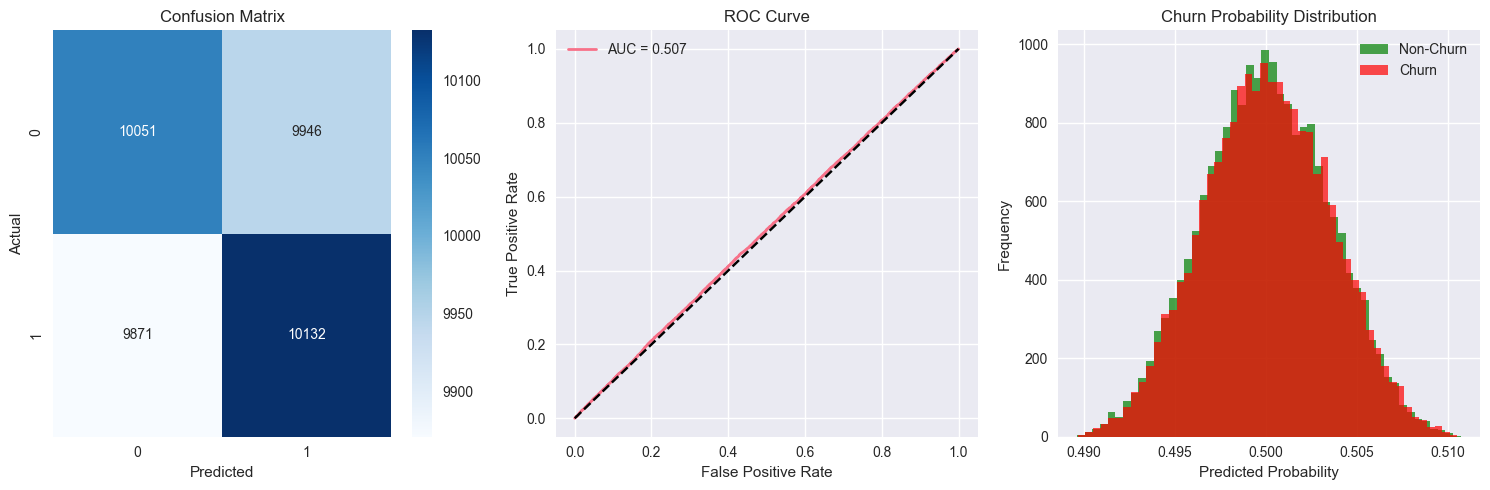


BUSINESS INSIGHTS AND RECOMMENDATIONS

1. HIGH-RISK CUSTOMER ANALYSIS:
Identified 0 customers with >70% churn probability
Segment distribution of high-risk customers:
Series([], Name: count, dtype: int64)

2. KEY DRIVERS OF CHURN:

3. RETENTION OPPORTUNITIES:
   - 0 loyal customers with low churn risk - Focus on retention

4. REGIONAL INSIGHTS:
   - High churn regions: 25 regions need special attention


In [19]:
# Detailed evaluation of best model
best_results = results[best_model_name]
y_pred_best = best_results['predictions']
y_pred_proba_best = best_results['probabilities']

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC Curve
plt.subplot(1, 3, 2)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {best_results["auc"]:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Probability Distribution
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba_best[y_test == 0], bins=50, alpha=0.7, label='Non-Churn', color='green')
plt.hist(y_pred_proba_best[y_test == 1], bins=50, alpha=0.7, label='Churn', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Churn Probability Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# Business Insights
print("\n" + "="*60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)

# 1. High-risk customer identification
high_risk_threshold = 0.7
high_risk_customers = data_segmented.iloc[X_test.index][y_pred_proba_best > high_risk_threshold]

print(f"\n1. HIGH-RISK CUSTOMER ANALYSIS:")
print(f"Identified {len(high_risk_customers)} customers with >{high_risk_threshold:.0%} churn probability")
print(f"Segment distribution of high-risk customers:")
print(high_risk_customers['segment_name'].value_counts())

# 2. Key drivers of churn
print(f"\n2. KEY DRIVERS OF CHURN:")
if hasattr(best_model, 'feature_importances_'):
    top_features = feature_importance.head(5)
    for _, row in top_features.iterrows():
        print(f"   - {row['feature']}: {row['importance']:.3f}")
 
# 3. Retention opportunities
print(f"\n3. RETENTION OPPORTUNITIES:")
# Filter test set rows first
test_customers = data_segmented.loc[X_test.index]
loyal_low_risk = test_customers[
    (test_customers['segment_name'] == 'Loyal Customers') & 
    (y_pred_proba_best < 0.3)
]
print(f"   - {len(loyal_low_risk)} loyal customers with low churn risk - Focus on retention")

# 4. Regional insights
print(f"\n4. REGIONAL INSIGHTS:")
regional_insights = data_segmented.groupby('region').agg({
    'churn': 'mean',
    'monthly_charges': 'mean'
}).round(3)
high_churn_regions = regional_insights[regional_insights['churn'] > regional_insights['churn'].median()]
print(f"   - High churn regions: {len(high_churn_regions)} regions need special attention")
